In [76]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import scipy.stats as st
import os
import math
import heapq
from scipy import stats
from scipy.stats import t, sem

In [77]:
SAVE_DIR = 'media'
os.makedirs(SAVE_DIR, exist_ok=True)
RANDOM_SEED = 42

# Defaults
N_SIM = 100
N_CUSTOMERS = 200
ARRIVAL_INTERVAL = 10.0
SERVICE_TIME = 12.0

### 1.
Using the Erlang C Formula (A. Willig, 1999), which calculates the probability of queuing we find the following:

#### M/M/2 Queue:

1. **Erlang C Formula**: 
   $$ P_w = \frac{\frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}}{\sum_{k=0}^{1} \frac{(\rho \cdot 2)^k}{k!} + \frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}} $$

2. **Average Waiting Time in Queue**:
   $$ W_q = \frac{P_w}{2\mu - \lambda} $$

3. **Total Average Time in System**:
   $$ W = W_q + \frac{1}{\mu} $$

#### M/M/1 Queue:

1. **Average Waiting Time in Queue**:
   $$ \rho' = \frac{\lambda'}{\mu} = \frac{\rho}{2} $$
   $$ W_q' = \frac{1}{\mu - \lambda'} $$

2. **Total Average Time in System**:
   $$ W' = W_q' + \frac{1}{\mu} $$

It makes sense that the queue time in a M/M/N system where $N>2$ has shorter queue times. Non-mathematically this can be thought as two supermarkets where one supermarket only has one cashier (N=1) available in comparison to the other supermarket that has two cashiers (N=2). Assuming same parameters, the supermarket with two cashiers will have higher throughput.

In [78]:
def erlangC(n, rho):
    """
    Calculate the Erlang C formula for a given number of servers and system load.

    The Erlang C formula is used in queue theory to determine the probability 
    that an arriving customer has to wait for service in an M/M/n queue.

    Parameters:
    n (int): The number of servers in the system.
    rho (float): The system load

    Returns:
    float: The probability of having to wait for service in the queue.
    """
    numerator = (rho**n / math.factorial(n)) * (1 / (1 - rho))
    denominator = sum([(rho**k) / math.factorial(k) for k in range(n)]) + numerator
    return numerator / denominator

def mxn_queue(lambda_rate, mu, n):
    """
    This function computes the average waiting time in the queue for a multi-server queue model.

    Parameters:
    lambda_rate (float): The arrival rate into the system.
    mu (float): The service rate of each individual server.
    n (int): The number of servers in the queue system.

    Returns:
    A float containing the average waiting time in the queue (Wq).
    """
    rho = lambda_rate / (n * mu) 
    Pw = erlangC(n, rho)
    Wq = Pw / (n * mu - lambda_rate) 
    return Wq

def mx1_queue(lambda_rate, mu, n):
    """
    This function computes the average waiting time in the queue for a single-server queue model.
    The arrival rate is adjusted to compare with an M/M/n queue.

    Parameters:
    lambda_rate (float): The total arrival rate into the system, to be adjusted for single-server comparison.
    mu (float): The service rate of the single server.
    n (int): The number of servers in the M/M/n system for comparison.

    Returns:
    A float containing the average waiting time in the queue (Wq').
    """
    adjusted_lambda = lambda_rate / n  # Adjusted lambda for comparison with M/M/n
    rho = adjusted_lambda / mu
    Wq_prime = 1 / (mu - adjusted_lambda)
    return Wq_prime


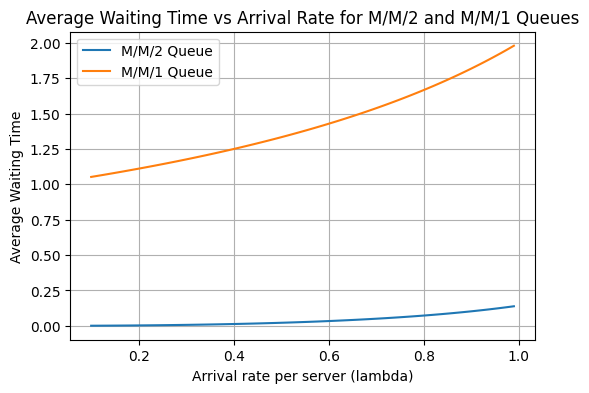

In [79]:
# Parameters
mu = 1
n = 2
lambda_rates = np.linspace(0.1, mu-0.01, 100)  # Vary lambda such that rho < 1 at all times

# Calculate waiting times for each value of lambda
waiting_times_mmn = [mxn_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]
waiting_times_mm1 = [mx1_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(lambda_rates, waiting_times_mmn, label='M/M/2 Queue')
plt.plot(lambda_rates, waiting_times_mm1, label='M/M/1 Queue')
plt.xlabel('Arrival rate per server (lambda)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Arrival Rate for M/M/2 and M/M/1 Queues')
plt.legend()
plt.grid(True)
plt.show()

### 2.
Using https://simpy.readthedocs.io/en/latest/examples/bank_renege.html tutorial code as base

In [80]:
def source(env, cst_total, arrival_interval, counters, store_wait_times, arrival_pdf='exp', service_pdf='exp', service_time=SERVICE_TIME, patience_time=None):
    """
    Generates customers at random intervals and initiates their service process.

    Parameters:
    env (simpy.Environment): The simulation environment.
    cst_total (int): The total number of customers to be generated in the simulation.
    arrival_interval (float): The average time interval between the arrivals of customers.
    counters (simpy.Resource): The service counter or resource to be used by customers.
    store_wait_times (list): A list to record the waiting times of each customer.
    arrival_pdf (str): The probability distribution function for customer arrival intervals. 
                       Options are 'exp' for exponential and 'const' for constant intervals.
    service_pdf (str): The probability distribution function for customer service times.
                       Options are 'exp' for exponential, 'const' for constant, and 'hyperexp' for hyperexponential.
    service_time (float): The average service time, used in service time calculations.

    Raises:
    ValueError: If an invalid distribution type is provided for either arrival or service intervals.
    """
    for i in range(cst_total):
        c = customer(env, f'Customer{i:02d}', counters, store_wait_times, service_pdf=service_pdf, service_time=service_time, patience_time=patience_time)
        env.process(c)
        if arrival_pdf == 'exp':
            t = random.expovariate(1.0 / arrival_interval)
        elif arrival_pdf == 'const':
            t = arrival_interval
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(t)

def customer(env, name, counters, store_wait_times, service_pdf='exp', service_time=SERVICE_TIME, hyperexp_p=0.25, hyperexp_factor=5, patience_time=None):   
    """
    Represents a customer arriving, being served, and leaving.

    This function models the behavior of a customer in the queue. It records the waiting time
    and the service time, depending on the specified distribution type for service.

    Parameters:
    env (simpy.Environment): The simulation environment.
    name (str): The name/id of the customer.
    counters (simpy.Resource): The service counter or resource being used by the customer.
    store_wait_times (list): A list to record the waiting time of the customer.
    service_pdf (str): The type of distribution for the service time ('exp' for exponential, 
                       'const' for constant, 'hyperexp' for hyperexponential).
    service_time (float): The average or base service time, used in service time calculations.
    hyperexp_p (float): The probability parameter used in the hyperexponential distribution, 
                        representing the probability of having a short service time.
    hyperexp_factor (float): A multiplier used to determine the longer service time in the hyperexponential distribution.

    Raises:
    ValueError: If an invalid distribution type is provided for service time.
    """
    arrive = env.now
    with counters.request() as req:
        if patience_time is not None:
            results = yield req | env.timeout(patience_time)
        else:
            results = yield req
        wait = env.now - arrive
        if service_pdf == 'exp':
            service_time = random.expovariate(1.0 / service_time) 
        elif service_pdf == 'const':
            service_time = 12.0
        elif service_pdf == 'hyperexp':
            r = random.random()
            if r < (1-hyperexp_p):
                service_time = random.expovariate(1.0 / service_time)
            else:
                service_time = random.expovariate(1.0 / (hyperexp_factor * service_time))
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(service_time)
        store_wait_times.append(wait)

def simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1, 2, 4], n_sim=N_SIM):
    """Run the simulations with provided parameters and return the waiting times and their averages"""
    wait_times_data = {n: [[] for _ in range(n_sim)] for n in ns}
    wait_times_data_mean = {n: [] for n in ns}
    for n in ns:
        for i in range(n_sim):
            random.seed(RANDOM_SEED+i)
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counter, wait_times, arrival_pdf=arrival_pdf, service_pdf=service_pdf))
            env.run()
            wait_times_data[n][i] = wait_times
            wait_times_data_mean[n].append(np.mean(wait_times))
    return wait_times_data, wait_times_data_mean

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, mean waiting time: {avg_wait_time:.2f}, std dev: {std_dev:.2f}, 95% CI ({c_low:.2e} | {c_high:.2e})')
    return avgs, stds, conf_intervals

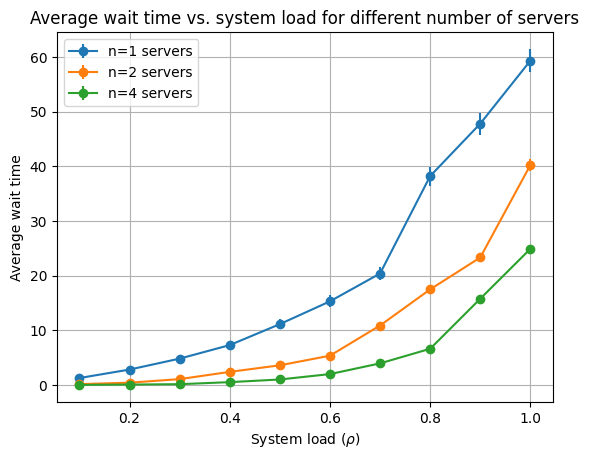

In [81]:
def run_simulation(num_servers, rho_values, mu, simulation_time, num_simulations):
    """Run the queue simulation for different values of system load (ρ)."""
    results = []
    for rho in rho_values:
        lambda_rate = rho * num_servers * mu  
        wait_times_aggregate = []
        for _ in range(num_simulations):
            env = simpy.Environment()
            wait_times = []
            env.process(source(env, N_CUSTOMERS, 1/lambda_rate, simpy.Resource(env, capacity=num_servers), wait_times))
            env.run(until=simulation_time)
            wait_times_aggregate.extend(wait_times)
        avg_wait = np.mean(wait_times_aggregate)
        std_dev = np.std(wait_times_aggregate)
        conf_interval = st.t.interval(0.997, len(wait_times_aggregate)-1, loc=avg_wait, scale=st.sem(wait_times_aggregate))
        results.append((rho, avg_wait, std_dev, conf_interval))
    return results

# Set parameters
MU = 1 / SERVICE_TIME
rho_values = np.linspace(0.1, 1.0, 10)
simulation_time = 1000
num_simulations = 100

# Run simulations for different server numbers
for num_servers in [1, 2, 4]:
    simulation_results = run_simulation(num_servers, rho_values, MU, simulation_time, num_simulations)
    # Plotting
    avg_wait_times = [result[1] for result in simulation_results]
    conf_intervals = [result[3] for result in simulation_results]
    errors = [(upper - lower) / 2 for lower, upper in conf_intervals]
    plt.errorbar(rho_values, avg_wait_times, yerr=errors, label=f'n={num_servers} servers', fmt='-o')

plt.xlabel('System load ($ρ$)')
plt.ylabel('Average wait time')
plt.title('Average wait time vs. system load for different number of servers')
plt.legend()
plt.grid(True)
plt.show()


Servers: 1, Average Waiting Time: 223.04, Std Dev: 67.76, 95% CI: lower 2.10e+02 | upper 2.37e+02
Servers: 2, Average Waiting Time: 3.59, Std Dev: 1.23, 95% CI: lower 3.34e+00 | upper 3.83e+00
Servers: 3, Average Waiting Time: 0.57, Std Dev: 0.25, 95% CI: lower 5.24e-01 | upper 6.25e-01
Servers: 4, Average Waiting Time: 0.11, Std Dev: 0.09, 95% CI: lower 9.21e-02 | upper 1.26e-01
Servers: 5, Average Waiting Time: 0.02, Std Dev: 0.03, 95% CI: lower 1.57e-02 | upper 2.94e-02


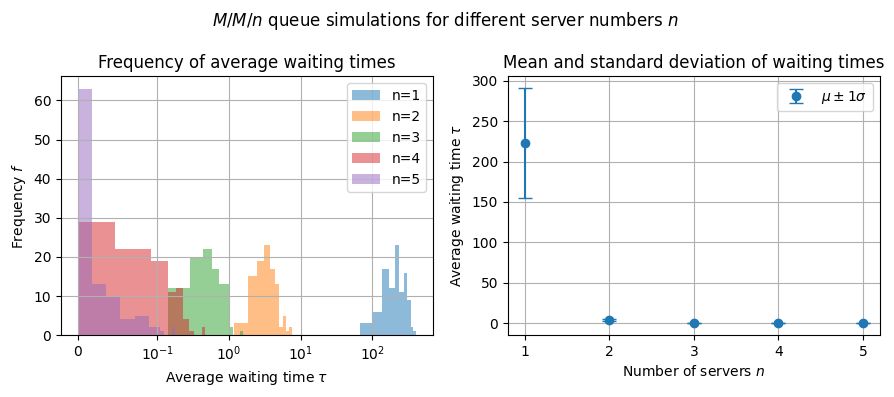

In [82]:
def simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1, 2, 4]):
    """Run the simulations with provided parameters and return the average waiting times"""
    wait_times_data = {n: [] for n in ns}
    for n in ns:
        for i in range(N_SIM):
            random.seed(RANDOM_SEED+i) # Same seed for reproducibility
            env = simpy.Environment()
            counters = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counters, wait_times, arrival_pdf=arrival_pdf, service_pdf=service_pdf, service_time=SERVICE_TIME))
            env.run()
            wait_times_data[n].append(np.mean(wait_times))
    return wait_times_data

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, Average Waiting Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: lower {c_low:.2e} | upper {c_high:.2e}')
    return avgs, stds, conf_intervals

def plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title):
    plt.figure(figsize=(9, 4), layout='tight')
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    for num_servers, times in wait_times_data.items():
        plt.hist(times, label=f'n={num_servers}', alpha=0.5)
    plt.xlabel('Average waiting time $\\tau$')
    plt.xscale('symlog', linthresh=0.1)
    plt.ylabel('Frequency $f$')
    plt.title('Frequency of average waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.errorbar(ns, avgs, yerr=stds, fmt='o', capsize=5, label='$\\mu \\pm 1\\sigma$')
    plt.xlabel('Number of servers $n$')
    plt.ylabel('Average waiting time $\\tau$')
    plt.title('Mean and standard deviation of waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.savefig(f'{SAVE_DIR}/{title.replace(' ', '_').replace('/', '-')}.png')
    plt.show()

# Experiment
ns = np.arange(1, 6, 1, dtype=int)
wait_times_data = simulate_experiments(arrival_pdf='exp', service_pdf='const', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title='$M/M/n$ queue simulations for different server numbers $n$')

Servers: 1, Average Waiting Time: 1410.28, Std Dev: 302.56, 95% CI: lower 1.35e+03 | upper 1.47e+03
Servers: 2, Average Waiting Time: 268.17, Std Dev: 129.41, 95% CI: lower 2.42e+02 | upper 2.94e+02
Servers: 3, Average Waiting Time: 31.20, Std Dev: 25.93, 95% CI: lower 2.60e+01 | upper 3.64e+01
Servers: 4, Average Waiting Time: 5.80, Std Dev: 5.44, 95% CI: lower 4.72e+00 | upper 6.89e+00
Servers: 5, Average Waiting Time: 1.50, Std Dev: 1.51, 95% CI: lower 1.20e+00 | upper 1.80e+00


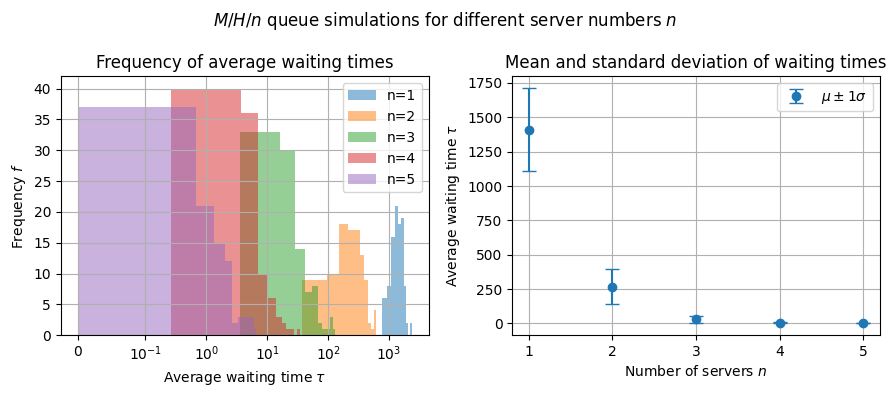

In [83]:
# Experiment
wait_times_data = simulate_experiments(arrival_pdf='exp', service_pdf='hyperexp', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title='$M/H/n$ queue simulations for different server numbers $n$')

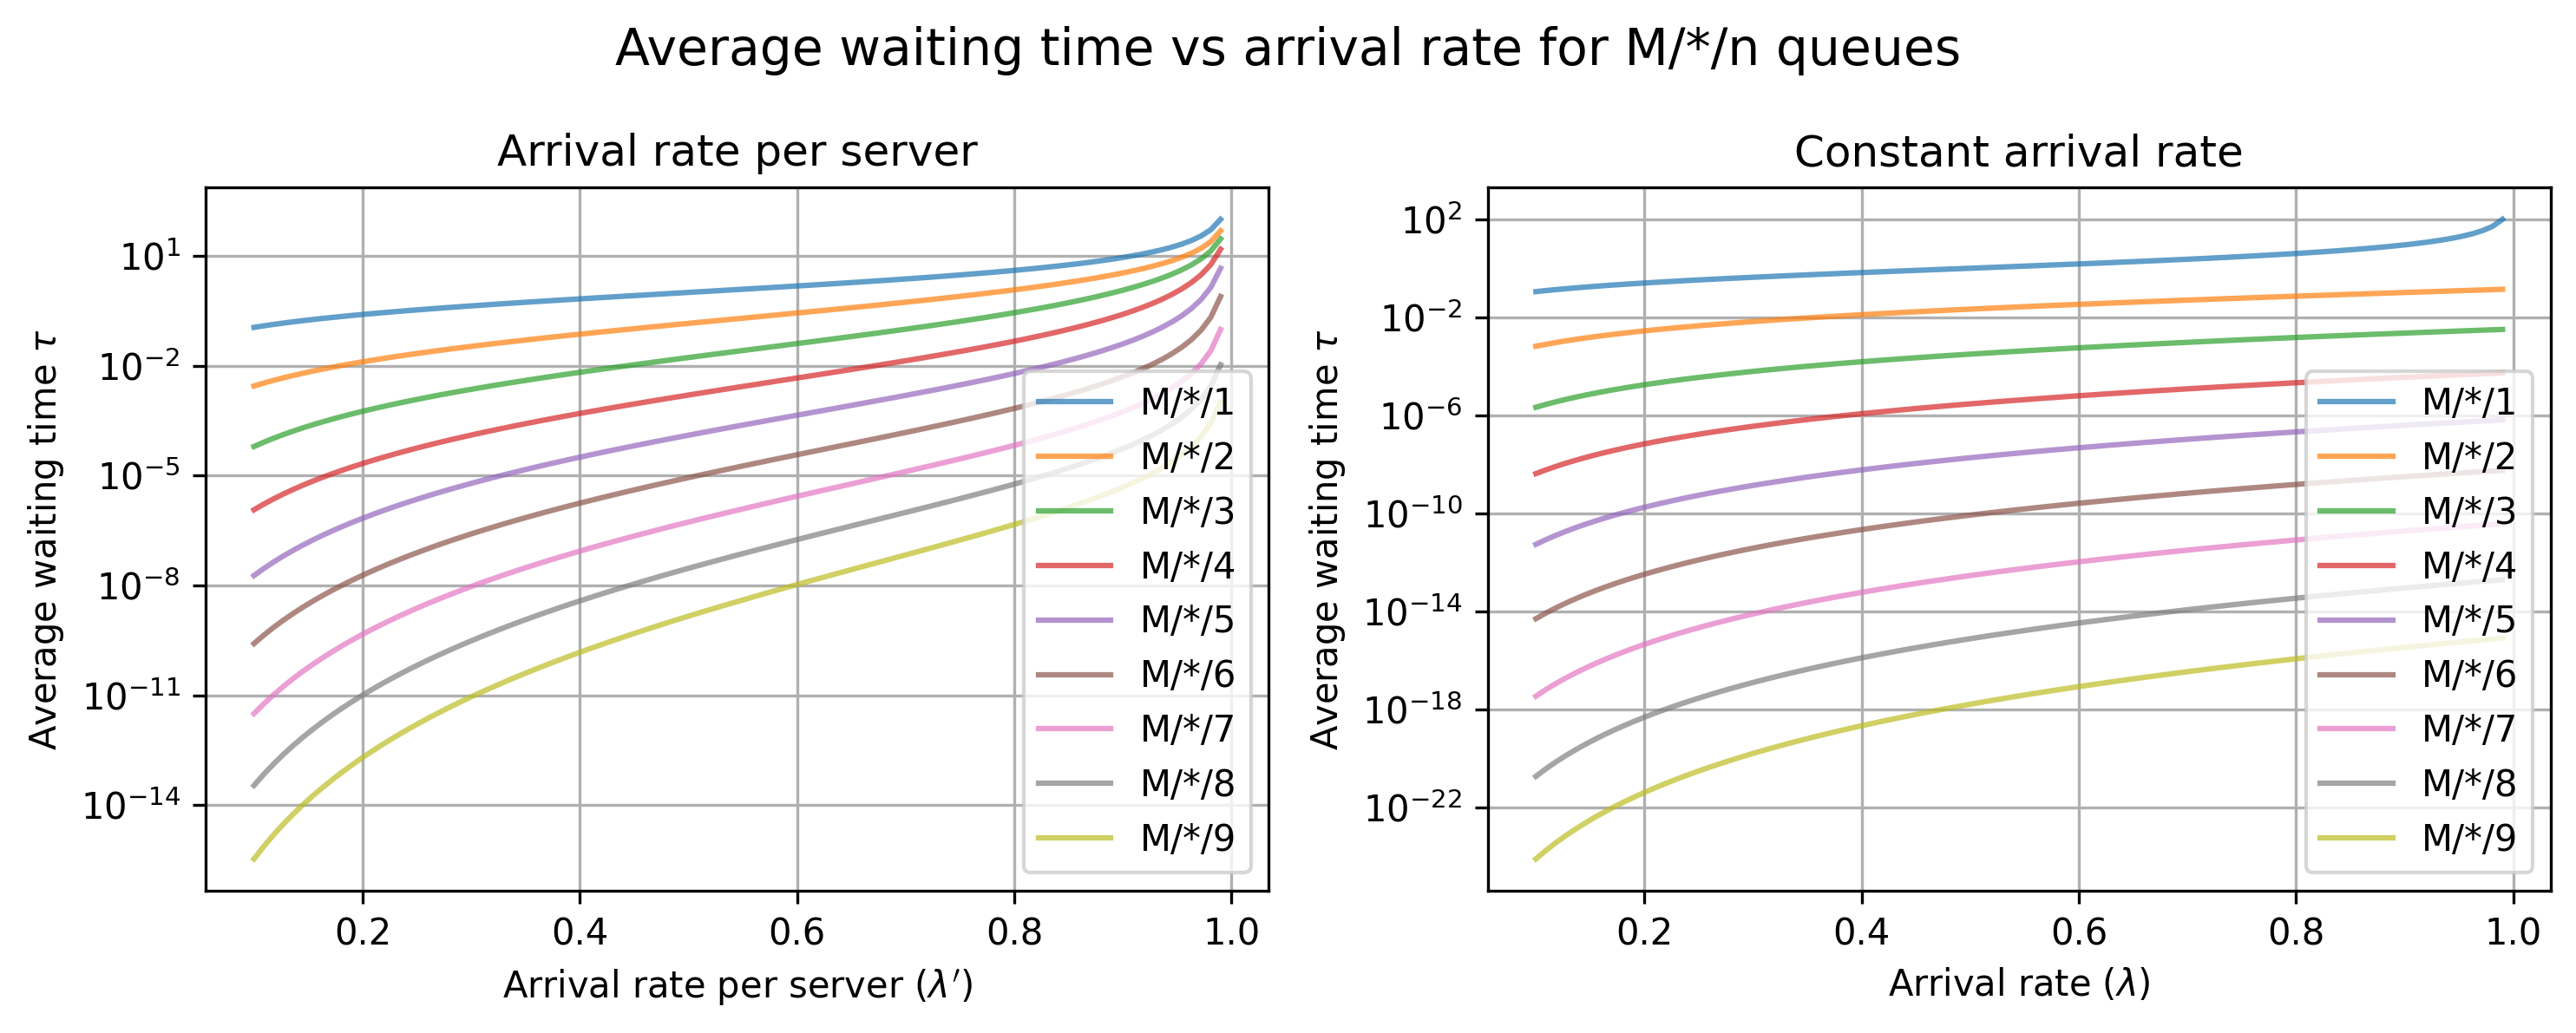

In [84]:
ns = np.arange(1, 10, dtype=int)
# Calculate waiting times for each value of lambda
waiting_times_mxns_pserv = {n: [] for n in ns}
waiting_times_mxns = {n: [] for n in ns}
for n in ns:
    waiting_times_mxns_pserv[n] = [mxn_queue(lambda_rate*n, mu, n) for lambda_rate in lambda_rates]
    waiting_times_mxns[n] = [mxn_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]
waiting_times_mx1 = [mx1_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(10, 4), dpi=300, layout='tight')
plt.suptitle('Average waiting time vs arrival rate for M/*/n queues', fontsize=14)
plt.subplot(1, 2, 1)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns_pserv[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate per server ($\\lambda\'$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Arrival rate per server')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate ($\\lambda$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Constant arrival rate')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
np.random.seed(RANDOM_SEED)

class Customer:
    """
    Represents a customer in the simulation.

    Attributes:
    ctype (int): Type of the customer, determining their priority.
    arrival_time (float): Simulation time at which the customer arrives.
    service_time (float): Duration required to service this customer.
    start_service_time (float): Simulation time when service starts.
    end_service_time (float): Simulation time when service ends.
    """
    def __init__(self, ctype, arrival_time, service_time):
        self.ctype = ctype  # Customer type
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.start_service_time = None
        self.end_service_time = None

    def wait_time(self):
        """Calculate the waiting time of the customer in the queue."""
        return self.start_service_time - self.arrival_time

def setup(env, n_servers, lambda_1, lambda_2, mu, priority_type='preemptive'):
    """
    Set up the simulation environment with priority queueing.

    Args:
    env (simpy.Environment): The simulation environment.
    n_servers (int): Number of servers in the simulation.
    lambda_1 (float): Arrival rate for type 1 customers.
    lambda_2 (float): Arrival rate for type 2 customers.
    mu (float): Service rate of the servers.
    priority_type (str): Type of priority ('preemptive' or 'non-preemptive').

    Returns:
    list: List of Customer objects created during the simulation.
    """
    # Setup the servers as priority resources
    servers = simpy.PriorityResource(env, capacity=n_servers)
    customers = []  # List to hold customers

    def customer_generator():
        """Generates customers and adds them to the simulation process."""
        while True:
            ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
            c = Customer(ctype, env.now, random.expovariate(1.0 / mu))
            env.process(customer_process(env, c, servers, priority_type))
            customers.append(c)
            yield env.timeout(random.expovariate(lambda_1 + lambda_2))

    def customer_process(env, customer, servers, priority_type):
        """Process for simulating customer queueing and service."""
        with servers.request(priority=(0 if customer.ctype == 1 else 1)) as req:
            yield req
            customer.start_service_time = env.now
            yield env.timeout(customer.service_time)
            customer.end_service_time = env.now

    env.process(customer_generator())
    return customers

# Run the simulation for a preemptive priority queue
env = simpy.Environment()
lambda_1 = 0.7  # Arrival rate of type 1 customers
lambda_2 = 0.4  # Arrival rate of type 2 customers
mu = 1.0  # Service rate
n_servers = 1  # Number of servers

# Run the simulation
customers = setup(env, n_servers, lambda_1, lambda_2, mu)
env.run(until=1000)  # Run the simulation for a certain amount of time

# Process data to calculate statistics
# Filter out customers who have not been served
wait_times = [c.wait_time() for c in customers if c.ctype == 1 and c.start_service_time is not None]

# Check if we have any wait times to process
if wait_times:
    avg_wait = np.mean(wait_times)
    std_wait = np.std(wait_times)
    conf_interval = st.t.interval(0.95, len(wait_times)-1, loc=avg_wait, scale=sem(wait_times))
    # Output the results
    print(f'Preemptive priority queue: Average Wait: {avg_wait:.2f}, Std Dev: {std_wait:.2f}, 95% CI: {conf_interval}')
else:
    print('No completed wait times to analyze.')

Preemptive priority queue: Average Wait: 3.15, Std Dev: 2.71, 95% CI: (2.9551091895100607, 3.3528573637591985)


In [86]:
def setup_non_preemptive(env, n_servers, lambda_1, lambda_2, mu):
    """
    Set up the simulation environment for a non-preemptive priority queue system.

    Args:
    env (simpy.Environment): The simulation environment.
    n_servers (int): Number of servers in the simulation.
    lambda_1 (float): Arrival rate for type 1 customers.
    lambda_2 (float): Arrival rate for type 2 customers.
    mu (float): Service rate of the servers.

    Returns:
    list: List of Customer objects created during the simulation.
    """
    servers = simpy.Resource(env, capacity=n_servers)
    customers = []

    def customer_generator():
        """Generates customers and adds them to the simulation process."""
        while True:
            ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
            c = Customer(ctype, env.now, random.expovariate(1.0 / mu))
            env.process(customer_process_non_preemptive(env, c, servers))
            customers.append(c)
            yield env.timeout(random.expovariate(lambda_1 + lambda_2))

    def customer_process_non_preemptive(env, customer, servers):
        """
        Process for simulating customer queuing and service in a non-preemptive queue.
        The customer waits for their turn and is served based on their arrival time.
        """
        # Wait for the server to become available. In non-preemptive priority, do not interrupt.
        # The priority is set by the order of arrival to the queue.
        with servers.request() as req:
            yield req
            customer.start_service_time = env.now
            yield env.timeout(customer.service_time)
            customer.end_service_time = env.now

    env.process(customer_generator())
    return customers

env = simpy.Environment()
lambda_1 = 0.7  # Arrival rate of type 1 customers
lambda_2 = 0.4  # Arrival rate of type 2 customers
mu = 1.0  # Service rate
n_servers = 1  # Number of servers

customers_non_preemptive = setup_non_preemptive(env, n_servers, lambda_1, lambda_2, mu)
env.run(until=1000)

wait_times_non_preemptive = [c.wait_time() for c in customers_non_preemptive if c.ctype == 1 and c.start_service_time is not None]

# Check if there are any wait times to process for non-preemptive queue
if wait_times_non_preemptive:
    avg_wait_non_preemptive = np.mean(wait_times_non_preemptive)
    std_wait_non_preemptive = np.std(wait_times_non_preemptive)
    conf_interval_non_preemptive = st.t.interval(0.95, len(wait_times_non_preemptive)-1, loc=avg_wait_non_preemptive, scale=st.sem(wait_times_non_preemptive))
    
    print(f'Non-preemptive priority queue: Average Wait: {avg_wait_non_preemptive:.2f}, Std Dev: {std_wait_non_preemptive:.2f}, 95% CI: {conf_interval_non_preemptive}')
else:
    print('No completed wait times to analyze for non-preemptive queue.')

Non-preemptive priority queue: Average Wait: 54.61, Std Dev: 23.05, 95% CI: (52.736373164244384, 56.4892409007182)


In [87]:
class SPTFCustomer:
    """
    Represents a customer in a Shortest Processing Time First (SPTF) queue simulation.

    Attributes:
    arrival_time (float): The time when the customer arrives in the simulation.
    service_time (float): The required service time for the customer.
    start_service_time (float): The time when the customer's service begins.
    """
    def __init__(self, arrival_time, service_time):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.start_service_time = None

    def wait_time(self):
        """Calculate the waiting time for the customer in the queue."""
        return self.start_service_time - self.arrival_time

def setup_sptf(env, n_servers, lambda_rate, service_time_distribution):
    """
    Set up the simulation environment for an SPTF queue system.

    Args:
    env (simpy.Environment): The simulation environment.
    n_servers (int): Number of servers in the simulation.
    lambda_rate (float): Arrival rate of customers.
    service_time_distribution (list): Distribution of service times for customers.

    Returns:
    list: A list of SPTFCustomer objects created during the simulation.
    """
    servers = simpy.Resource(env, capacity=n_servers)
    queue = []  # Min-heap for customers based on service time
    customers = []

    def customer_generator():
        """Generates customers and adds them to the simulation process."""
        cust_id = 0
        while True:
            service_time = random.choice(service_time_distribution)
            c = SPTFCustomer(env.now, service_time)
            heapq.heappush(queue, (service_time, env.now, c))
            # print(f"[{env.now}] Customer {cust_id} generated with service time {service_time}")
            customers.append(c)  # Add this line to record each customer
            cust_id += 1
            yield env.timeout(random.expovariate(lambda_rate))

    def server():
        """Server process handling customers based on their service time."""
        while True:
            if queue:
                _, _, customer = heapq.heappop(queue)
                customer.start_service_time = env.now
                yield env.timeout(customer.service_time)
                customer.end_service_time = env.now
            else:
                print(f"[{env.now}] Server waiting for customers")
                yield env.timeout(1)

    env.process(customer_generator())
    for _ in range(n_servers):
        env.process(server())

    return customers

env = simpy.Environment()
lambda_rate = 0.7
mu = 1.0
n_servers = 1
service_time_distribution = [1, 2, 3, 4, 5]  # Service times for SPTF

customers_sptf = setup_sptf(env, n_servers, lambda_rate, service_time_distribution)
env.run(until=1000)

wait_times_sptf = [c.wait_time() for c in customers_sptf if c.start_service_time is not None]

if wait_times_sptf:
    avg_wait_sptf = np.mean(wait_times_sptf)
    std_wait_sptf = np.std(wait_times_sptf)
    conf_interval_sptf = st.t.interval(0.95, len(wait_times_sptf)-1, loc=avg_wait_sptf, scale=st.sem(wait_times_sptf))
    # Output the results for SPTF queue
    print(f'SPTF queue: Average Wait: {avg_wait_sptf:.2f}, Std Dev: {std_wait_sptf:.2f}, 95% CI: {conf_interval_sptf}')
else:
    print('No completed wait times to analyze for SPTF queue.')

SPTF queue: Average Wait: 50.94, Std Dev: 158.59, 95% CI: (36.21013049264224, 65.66126284920733)


[1] Server waiting for customers
[2] Server waiting for customers
[3] Server waiting for customers
Preemptive Priority Queue: Average Wait: 3.00, Std Dev: 3.07, 95% CI: (2.7696289071453886, 3.225507487647746)
Non-Preemptive Priority Queue: Average Wait: 23.78, Std Dev: 11.37, 95% CI: (22.892263416290223, 24.658143885914146)
SPTF Priority Queue: Average Wait: 43.64, Std Dev: 142.83, 95% CI: (30.70509645437144, 56.56982728933991)
FIFO Priority Queue: Average Wait: 253.28, Std Dev: 112.47, 95% CI: (230.85358983944727, 275.7126815629157)


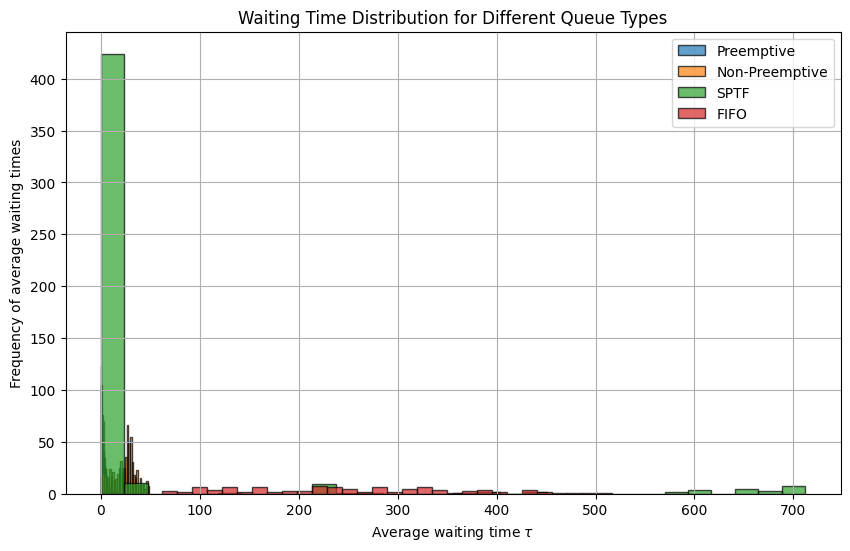

In [88]:
def run_sptf_simulation(n_servers, lambda_rate, service_time_distribution):
    """
    Run a simulation for an SPTF (Shortest Processing Time First) queue.

    Args:
    n_servers (int): Number of servers in the simulation.
    lambda_rate (float): Arrival rate of customers.
    service_time_distribution (list): Distribution of service times for customers.

    Returns:
    list: Wait times of customers in the SPTF queue.
    """
    env = simpy.Environment()
    customers = setup_sptf(env, n_servers, lambda_rate, service_time_distribution)
    env.run(until=1000)
    wait_times = [c.wait_time() for c in customers if c.start_service_time is not None]
    return wait_times

def run_priority_queue_simulations(n_servers, queue_type):
    """
    Run simulations for different types of priority queues.

    Args:
    n_servers (int): Number of servers in the simulation.
    queue_type (str): Type of the priority queue ('preemptive', 'non-preemptive', or 'sptf').

    Returns:
    list: Wait times of customers for the specified queue type.
    """
    env = simpy.Environment()
    lambda_1, lambda_2 = 0.7, 0.4
    mu = 1.0
    service_time_distribution = [1, 2, 3, 4, 5]

    if queue_type in ['preemptive', 'non-preemptive']:
        setup_function = setup if queue_type == 'preemptive' else setup_non_preemptive
        customers = setup_function(env, n_servers, lambda_1, lambda_2, mu)
    elif queue_type == 'sptf':
        customers = run_sptf_simulation(n_servers, lambda_1 + lambda_2, service_time_distribution)
    else:
        raise ValueError("Invalid queue type")

    env.run(until=1000)
    wait_times = [c.wait_time() for c in customers if c.ctype == 1 and c.start_service_time is not None] if queue_type != 'sptf' else [c.wait_time() for c in customers if c.start_service_time is not None]
    return wait_times

# Run simulations and gather data for each queue type
wait_times_preemptive = run_priority_queue_simulations(1, 'preemptive')
wait_times_non_preemptive = run_priority_queue_simulations(1, 'non-preemptive')
wait_times_sptf = run_sptf_simulation(1, lambda_rate, service_time_distribution)
wait_times_fifo = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1])[1]

# Perform statistical analysis and visualize results for each queue type
for wait_times, queue_type in [(wait_times_preemptive, 'Preemptive'), 
                               (wait_times_non_preemptive, 'Non-Preemptive'),
                               (wait_times_sptf, 'SPTF'),
                               (wait_times_fifo, 'FIFO')]:
    avg_wait = np.mean(wait_times)
    std_wait = np.std(wait_times)
    conf_interval = st.t.interval(0.95, len(wait_times)-1, loc=avg_wait, scale=sem(wait_times))
    print(f'{queue_type} Priority Queue: Average Wait: {avg_wait:.2f}, Std Dev: {std_wait:.2f}, 95% CI: {conf_interval}')

plt.figure(figsize=(10, 6))
plt.hist(wait_times_preemptive, bins=30, alpha=0.7, label='Preemptive', edgecolor='black')
plt.hist(wait_times_non_preemptive, bins=30, alpha=0.7, label='Non-Preemptive', edgecolor='black')
plt.hist(wait_times_sptf, bins=30, alpha=0.7, label='SPTF', edgecolor='black')
plt.hist(wait_times_fifo, bins=30, alpha=0.7, label='FIFO', edgecolor='black')
plt.xlabel('Average waiting time $\\tau$')
plt.ylabel('Frequency of average waiting times')
plt.title('Waiting Time Distribution for Different Queue Types')
plt.legend()
plt.grid(True)
plt.show()

Preemptive Priority Queue: Average Wait: 3.88, Std Dev: 3.19, 95% CI: (3.652318230611535, 4.115944378652166)
Non-Preemptive Priority Queue: Average Wait: 45.74, Std Dev: 23.71, 95% CI: (43.804454432467885, 47.66808517058973)
FIFO Priority Queue: Average Wait: 253.28, Std Dev: 112.47, 95% CI: (230.85358983944727, 275.7126815629157)


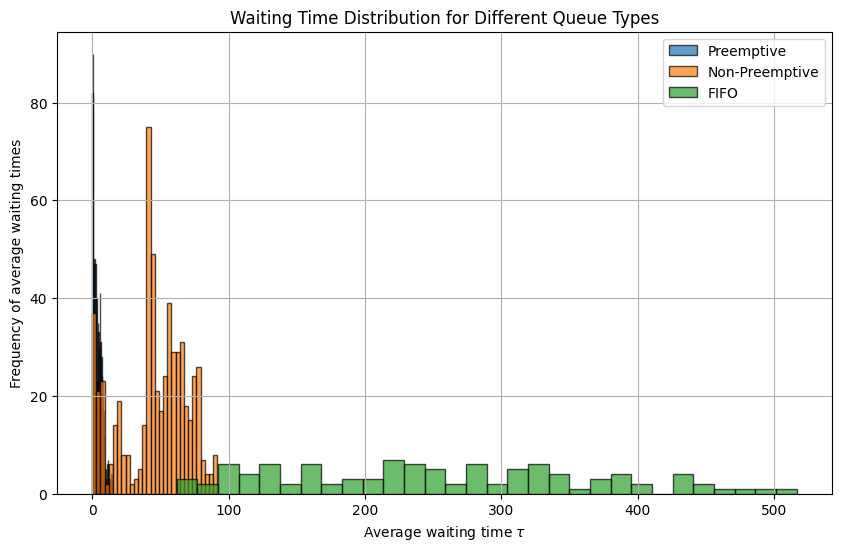

In [89]:
# Run simulations again for better comparison with FIFO, preemptive and non-preemptive
wait_times_preemptive = run_priority_queue_simulations(1, 'preemptive')
wait_times_non_preemptive = run_priority_queue_simulations(1, 'non-preemptive')
wait_times_fifo = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1])[1]  # For M/M/1 queue

for wait_times, queue_type in [(wait_times_preemptive, 'Preemptive'), 
                               (wait_times_non_preemptive, 'Non-Preemptive'),
                               (wait_times_fifo, 'FIFO')]:
    avg_wait = np.mean(wait_times)
    std_wait = np.std(wait_times)
    conf_interval = st.t.interval(0.95, len(wait_times)-1, loc=avg_wait, scale=sem(wait_times))
    print(f'{queue_type} Priority Queue: Average Wait: {avg_wait:.2f}, Std Dev: {std_wait:.2f}, 95% CI: {conf_interval}')

plt.figure(figsize=(10, 6))
plt.hist(wait_times_preemptive, bins=30, alpha=0.7, label='Preemptive', edgecolor='black')
plt.hist(wait_times_non_preemptive, bins=30, alpha=0.7, label='Non-Preemptive', edgecolor='black')
plt.hist(wait_times_fifo, bins=30, alpha=0.7, label='FIFO', edgecolor='black')
plt.xlabel('Average waiting time $\\tau$')
plt.ylabel('Frequency of average waiting times')
plt.title('Waiting Time Distribution for Different Queue Types')
plt.legend()
plt.grid(True)
plt.show()

[2] Server waiting for customers
[3] Server waiting for customers
[4] Server waiting for customers
[5] Server waiting for customers
[10] Server waiting for customers
[11] Server waiting for customers
[12] Server waiting for customers
[13] Server waiting for customers
[14] Server waiting for customers
[15] Server waiting for customers
[16] Server waiting for customers
[17] Server waiting for customers
[18] Server waiting for customers
[19] Server waiting for customers
[20] Server waiting for customers
[21] Server waiting for customers
[22] Server waiting for customers
[23] Server waiting for customers
[24] Server waiting for customers
[25] Server waiting for customers
[26] Server waiting for customers
[27] Server waiting for customers
[28] Server waiting for customers
[29] Server waiting for customers
[30] Server waiting for customers
[31] Server waiting for customers
[32] Server waiting for customers
[33] Server waiting for customers
[34] Server waiting for customers
[35] Server waitin

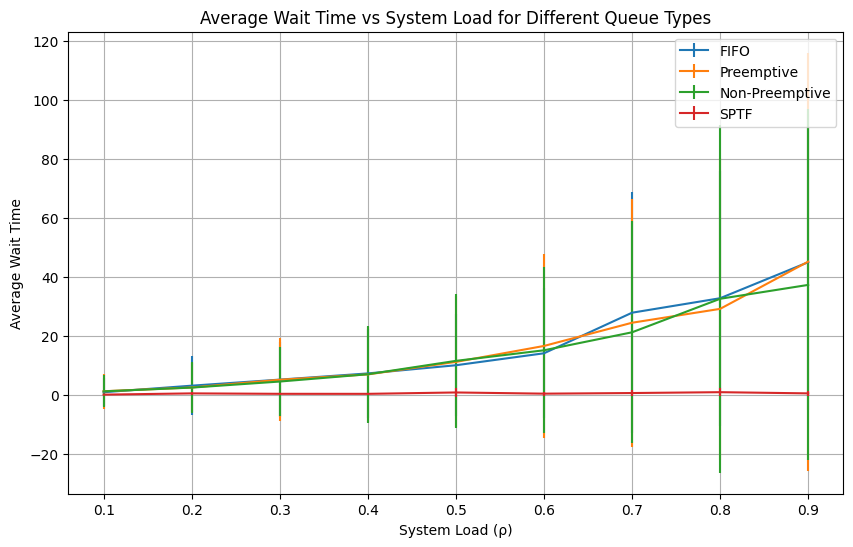

In [90]:
SIMULATION_TIME = 1000
N_SIMULATIONS = 100

def run_sptf_simulation(n_servers, lambda_rate, service_time_distribution):
    """
    Run a simulation for a Shortest Processing Time First (SPTF) queue.

    Args:
    n_servers (int): Number of servers in the simulation.
    lambda_rate (float): Arrival rate of customers.
    service_time_distribution (list): Distribution of service times for customers.

    Returns:
    tuple: Average and standard deviation of wait times for the SPTF queue.
    """
    env = simpy.Environment()
    customers = setup_sptf(env, n_servers, lambda_rate, service_time_distribution)
    env.run(until=1000)
    wait_times = [c.wait_time() for c in customers if c.start_service_time is not None]
    avg_wait = np.mean(wait_times) if wait_times else float('nan')
    std_wait = np.std(wait_times) if wait_times else float('nan')
    return avg_wait, std_wait

def simulate_fifo(env, lambda_rate, mu, wait_times):
    resource = simpy.Resource(env, capacity=1)
    for _ in range(N_CUSTOMERS):
        env.process(customer(env, resource, lambda_rate, mu, wait_times))
        yield env.timeout(random.expovariate(lambda_rate))

def simulate_preemptive(env, lambda_1, lambda_2, mu, wait_times):
    resource = simpy.PriorityResource(env, capacity=1)
    for _ in range(N_CUSTOMERS):
        ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
        env.process(customer_with_priority(env, resource, mu, wait_times, priority=0 if ctype == 1 else 1))
        yield env.timeout(random.expovariate(lambda_1 + lambda_2))

def simulate_non_preemptive(env, lambda_1, lambda_2, mu, wait_times):
    resource = simpy.PriorityResource(env, capacity=1)
    for _ in range(N_CUSTOMERS):
        ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
        env.process(customer_with_priority(env, resource, mu, wait_times, priority=ctype))
        yield env.timeout(random.expovariate(lambda_1 + lambda_2))

def simulate_sptf(env, lambda_rate, service_time_distribution, wait_times):
    resource = simpy.Resource(env, capacity=1)
    queue = []

    def customer_sptf():
        while True:
            service_time = np.random.choice(service_time_distribution)
            arrival_time = env.now
            heapq.heappush(queue, (service_time, arrival_time))
            yield env.timeout(random.expovariate(lambda_rate))

    def server():
        while True:
            if queue:
                service_time, arrival_time = heapq.heappop(queue)
                with resource.request() as req:
                    yield req
                    wait = env.now - arrival_time
                    yield env.timeout(service_time)
                    wait_times.append(wait)
            else:
                # Ensure server process does not terminate by yielding a timeout
                yield env.timeout(0.1)

    env.process(customer_sptf())
    env.process(server())

def customer(env, resource, lambda_rate, mu, wait_times):
    arrive = env.now
    with resource.request() as req:
        yield req
        wait = env.now - arrive
        yield env.timeout(random.expovariate(mu))
        wait_times.append(wait)

def customer_with_priority(env, resource, mu, wait_times, priority):
    arrive = env.now
    with resource.request(priority=priority) as req:
        yield req
        wait = env.now - arrive
        yield env.timeout(random.expovariate(mu))
        wait_times.append(wait)

def run_simulation(simulate_function, *args):
    """
    Run a set of simulations using a specified simulation function and parameters.

    Args:
    simulate_function (function): The simulation function to be executed.
    *args: Variable length argument list for the simulation function.

    Returns:
    tuple: Average and standard deviation of wait times across all simulations.
    """
    wait_times = []
    for _ in range(N_SIMULATIONS):
        env = simpy.Environment()
        env.process(simulate_function(env, *args, wait_times))
        env.run(until=SIMULATION_TIME)
    return np.mean(wait_times), np.std(wait_times)

service_time_distribution = [1, 2, 3, 4, 5]
rho_values = np.linspace(0.1, 0.9, 9)  # Varying ρ from 0.1 to 0.9
results = {'FIFO': [], 'Preemptive': [], 'Non-Preemptive': [], 'SPTF': []}

for rho in rho_values:
    lambda_rate = rho * MU

    avg_wait, std_wait = run_simulation(simulate_fifo, lambda_rate, MU)
    results['FIFO'].append((avg_wait, std_wait))

    avg_wait, std_wait = run_simulation(simulate_preemptive, lambda_rate / 2, lambda_rate / 2, MU)
    results['Preemptive'].append((avg_wait, std_wait))

    avg_wait, std_wait = run_simulation(simulate_non_preemptive, lambda_rate / 2, lambda_rate / 2, MU)
    results['Non-Preemptive'].append((avg_wait, std_wait))
    
    avg_wait, std_wait = run_sptf_simulation(1, lambda_rate, service_time_distribution)
    results['SPTF'].append((avg_wait, std_wait))

plt.figure(figsize=(10, 6))
for queue_type, data in results.items():
    avg_waits = [item[0] for item in data]
    std_devs = [item[1] for item in data]
    plt.errorbar(rho_values, avg_waits, yerr=std_devs, label=queue_type)

plt.xlabel('System Load (ρ)')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs System Load for Different Queue Types')
plt.legend()
plt.grid(True)
plt.show()

[4] Server waiting for customers
[5] Server waiting for customers
[6] Server waiting for customers
[7] Server waiting for customers
[8] Server waiting for customers
[9] Server waiting for customers
[10] Server waiting for customers
[11] Server waiting for customers
[12] Server waiting for customers
[13] Server waiting for customers
[14] Server waiting for customers
[15] Server waiting for customers
[16] Server waiting for customers
[17] Server waiting for customers
[18] Server waiting for customers
[19] Server waiting for customers
[20] Server waiting for customers
[21] Server waiting for customers
[22] Server waiting for customers
[23] Server waiting for customers
[24] Server waiting for customers
[25] Server waiting for customers
[26] Server waiting for customers
[27] Server waiting for customers
[28] Server waiting for customers
[29] Server waiting for customers
[30] Server waiting for customers
[31] Server waiting for customers
[32] Server waiting for customers
[33] Server waiting 

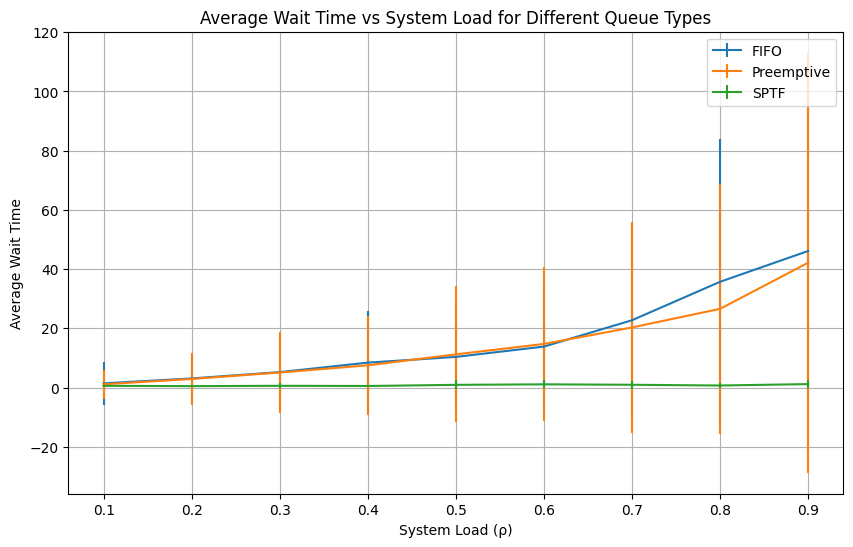

In [92]:
# Run simulations again for better comparison with FIFO, preemptive and SPTF
service_time_distribution = [1, 2, 3, 4, 5]
rho_values = np.linspace(0.1, 0.9, 9)  # Varying ρ from 0.1 to 0.9
results = {'FIFO': [], 'Preemptive': [], 'SPTF': []}

for rho in rho_values:
    lambda_rate = rho * MU

    avg_wait, std_wait = run_simulation(simulate_fifo, lambda_rate, MU)
    results['FIFO'].append((avg_wait, std_wait))

    avg_wait, std_wait = run_simulation(simulate_preemptive, lambda_rate / 2, lambda_rate / 2, MU)
    results['Preemptive'].append((avg_wait, std_wait))

    avg_wait, std_wait = run_sptf_simulation(1, lambda_rate, service_time_distribution)
    results['SPTF'].append((avg_wait, std_wait))

plt.figure(figsize=(10, 6))
for queue_type, data in results.items():
    avg_waits = [item[0] for item in data]
    std_devs = [item[1] for item in data]
    plt.errorbar(rho_values, avg_waits, yerr=std_devs, label=queue_type)

plt.xlabel('System Load (ρ)')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs System Load for Different Queue Types')
plt.legend()
plt.grid(True)
plt.show()